## Importing libraries

In [113]:
from zipfile import ZipFile
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from collections import Counter
warnings.filterwarnings("ignore")
pd.set_option("display.max_colwidth",None)

## Loading Data

In [114]:
train = pd.read_csv("Train.csv")
test = pd.read_csv("Test.csv")
ID = test["Transaction_ID"]

Getting the first insight from the data to obtain the general understanding from the data

In [115]:
train.shape,train.size

((373, 12), 4476)

In [116]:
train.describe()

,PURCHASE_VALUE,USER_AGE,USER_HOUSEHOLD,USER_INCOME
count,373.000000,61.000000,373.000000,373.000000
mean,4506.522788,25.803279,2.831099,146235.924933
std,15722.261797,1.423841,1.600033,166521.780346
min,10.000000,25.000000,1.000000,8000.000000
25%,150.000000,25.000000,1.000000,23000.000000
50%,690.000000,25.000000,3.000000,90000.000000
75%,2000.000000,27.000000,4.000000,200000.000000
max,150000.000000,32.000000,7.000000,1000000.000000


In [117]:
np.sum(train.isnull())

MERCHANT_CATEGORIZED_AT                    0
MERCHANT_NAME                              0
MERCHANT_CATEGORIZED_AS                    0
PURCHASE_VALUE                             0
PURCHASED_AT                               0
IS_PURCHASE_PAID_VIA_MPESA_SEND_MONEY      0
USER_AGE                                 312
USER_GENDER                                6
USER_HOUSEHOLD                             0
USER_INCOME                                0
USER_ID                                    0
Transaction_ID                             0
dtype: int64

USER_AGE seems to hold some of the null values will try to use missing value handling techiniques such as filling,replacing or drop them completely

In [118]:
train["split"] = -777
test["split"] = -888
#extra["split"] = -999
data = pd.concat([train,test]).reset_index(drop=True)

In [119]:
data.dtypes

MERCHANT_CATEGORIZED_AT                   object
MERCHANT_NAME                             object
MERCHANT_CATEGORIZED_AS                   object
PURCHASE_VALUE                             int64
PURCHASED_AT                              object
IS_PURCHASE_PAID_VIA_MPESA_SEND_MONEY       bool
USER_AGE                                 float64
USER_GENDER                               object
USER_HOUSEHOLD                             int64
USER_INCOME                                int64
USER_ID                                   object
Transaction_ID                            object
split                                      int64
dtype: object

In [120]:
viz_data = data.copy()
try:
    del viz_data["MERCHANT_CATEGORIZED_AT"],viz_data["USER_ID"],viz_data["Transaction_ID"],viz_data["USER_AGE"],viz_data["split"]
    #del train["MERCHANT_NAME"],train["USER_AGE"]
except Exception:
    print("Already dropped")
#data["USER_AGE"] = data["USER_AGE"].fillna(data["USER_AGE"].median())
#train = pd.get_dummies(train,columns=["MERCHANT_NAME"])

## Data visualization

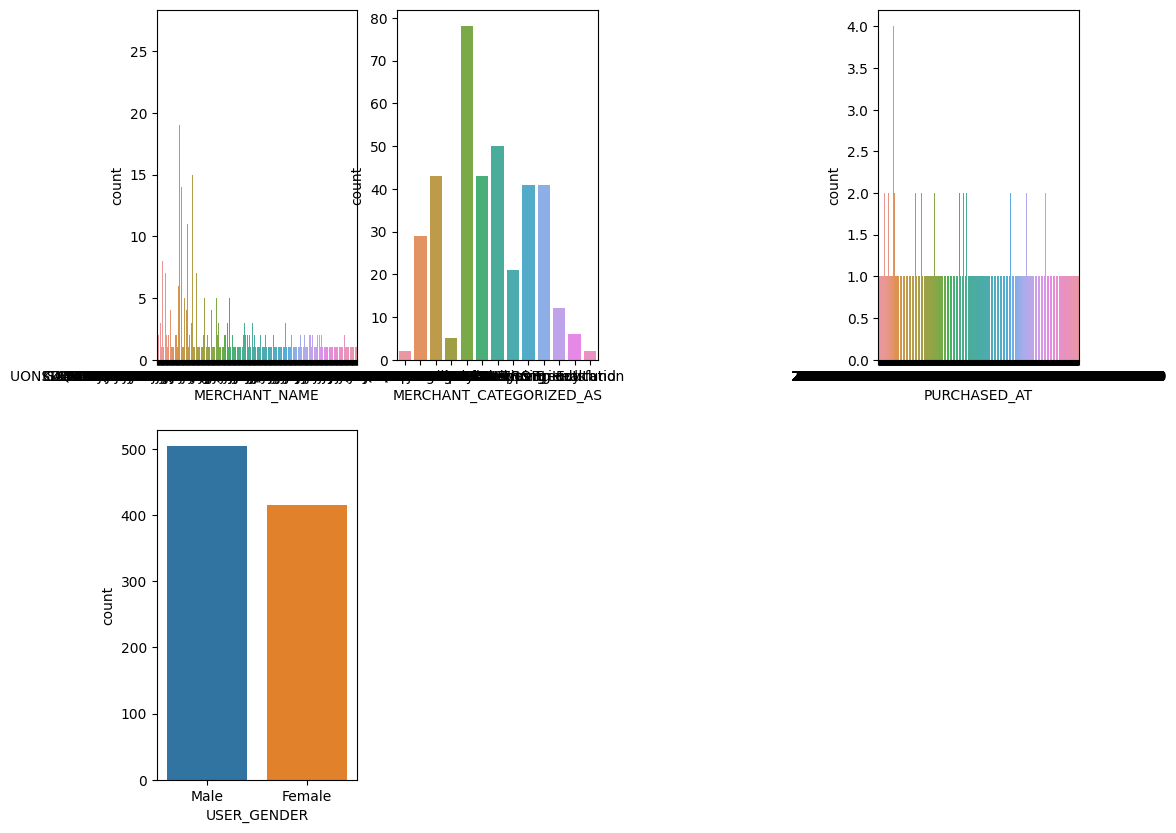

In [129]:
plt.figure(figsize=(15,10))
c = 1
for i in viz_data:
    if data[i].dtypes == object:
        try:
            plt.subplot(2,5,c)
        except:
            pass
        sns.countplot(viz_data[i])
    c = c + 1
plt.show()

In [80]:
data["PURCHASED_AT"] = pd.to_datetime(data["PURCHASED_AT"]).dt.tz_localize(None)
data["PURCHASE_DATE"] = pd.to_datetime(data["PURCHASED_AT"]).dt.day
data["PURCHASE_MONTH"] = pd.to_datetime(data["PURCHASED_AT"]).dt.month
data["PURCHASE_YEAR"] = pd.to_datetime(data["PURCHASED_AT"]).dt.year
del data["PURCHASED_AT"]

In [81]:
data.dtypes

MERCHANT_NAME                            object
MERCHANT_CATEGORIZED_AS                  object
PURCHASE_VALUE                            int64
IS_PURCHASE_PAID_VIA_MPESA_SEND_MONEY      bool
USER_GENDER                              object
USER_HOUSEHOLD                            int64
USER_INCOME                               int64
split                                     int64
PURCHASE_DATE                             int64
PURCHASE_MONTH                            int64
PURCHASE_YEAR                             int64
dtype: object

In [66]:
data = pd.get_dummies(data,columns=["MERCHANT_NAME"])

In [67]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
for i in data:
    if data[i].dtypes == 'O' or data[i].dtypes ==  bool:
        data[i] = le.fit_transform(data[i])

In [68]:
train = data[data["split"] == -777]
test = data[data["split"] == -888]
extra = data[data["split"] == -999]
del train["split"],test["split"]
del extra["MERCHANT_CATEGORIZED_AS"],extra["split"],test["MERCHANT_CATEGORIZED_AS"]

In [133]:
y = train["MERCHANT_CATEGORIZED_AS"]
del train["MERCHANT_CATEGORIZED_AS"]
X = train

<AxesSubplot:xlabel='MERCHANT_CATEGORIZED_AS', ylabel='count'>

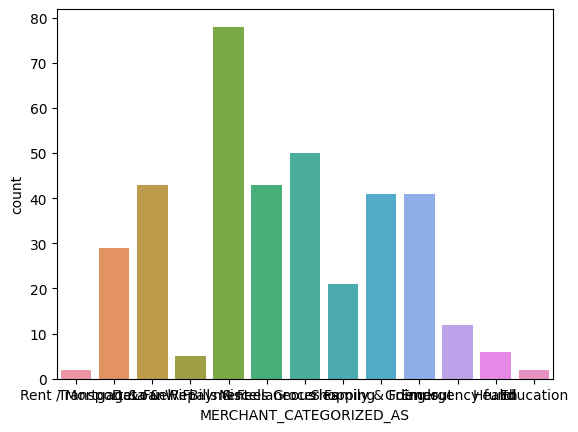

In [134]:
sns.countplot(y)

In [135]:
from imblearn.over_sampling import RandomOverSampler
ros = RandomOverSampler()
X,y = ros.fit_resample(X,y)
X,y = np.array(X),np.array(y)

<AxesSubplot:ylabel='count'>

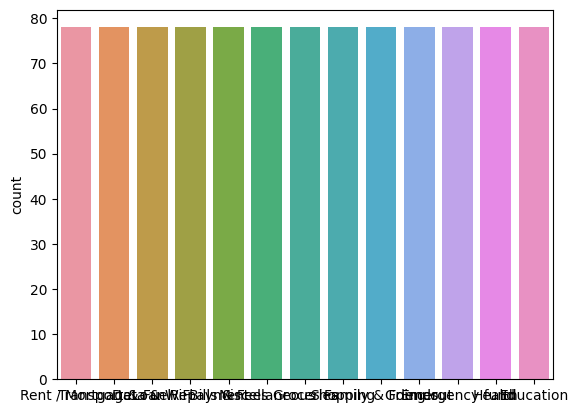

In [136]:
sns.countplot(y)

In [185]:
from sklearn.model_selection import StratifiedKFold,cross_val_score
from sklearn.metrics import log_loss,accuracy_score
sk = StratifiedKFold()
for train_index,test_index in sk.split(X,y):
    X_train,y_train = X[train_index],y[train_index]
    X_test,y_test = X[test_index],y[test_index]

In [186]:
from lightgbm import LGBMClassifier
lg = LGBMClassifier(
    n_estimators=100,
    boosting_type="gbdt",
    learning_rate=0.08,#0.08
    num_leaves=32,
     random_state=0
)
lg.fit(X_train,y_train)
pr_lg = lg.predict_proba(X_test)
lg.score(X_train,y_train),lg.score(X_test,y_test),log_loss(y_test,pr_lg)

(0.9975369458128078, 0.9554455445544554, 0.1820362378532085)

In [155]:
from catboost import CatBoostClassifier
cb = CatBoostClassifier(
     silent=True,
     n_estimators=60,
     learning_rate=0.8,
     depth=10,#10
     #random_state=2030
)
cb.fit(X_train,y_train)
pr_cb = cb.predict_proba(X_test)
cb.score(X_train,y_train),cb.score(X_test,y_test),log_loss(y_test,pr_cb)

(0.9889162561576355, 0.9653465346534653, 0.39544960191397543)

In [156]:
from sklearn.ensemble import BaggingClassifier
bg = BaggingClassifier(
    base_estimator=cb,
    random_state=2030
)
bg.fit(X_train,y_train)
pr_bg = bg.predict_proba(X_test)
bg.score(X_train,y_train),bg.score(X_test,y_test),log_loss(y_test,pr_bg)

(0.9901477832512315, 0.9653465346534653, 0.40320067156035083)

In [210]:
# est = [("cb",cb),("lg",lg)]
# sc = StackingClassifier(
#     estimators=est
# )
# sc.fit(X_train,y_train)
# pr_sk = sc.predict_proba(X_test)
# sc.score(X_train,y_train),sc.score(X_test,y_test),log_loss(y_test,pr_sk)

In [157]:
cols = ['Bills & Fees','Data & WiFi','Education','Emergency fund','Family & Friends','Going out','Groceries',
 'Health','Loan Repayment','Miscellaneous','Rent / Mortgage','Shopping','Transport & Fuel']

In [158]:
#test = np.array(test)
predicts = bg.predict_proba(test)
subm = pd.DataFrame(predicts,columns=cols)
subm = pd.concat([ID,subm],join="inner",axis=1)
subm.to_csv("solution.csv",index=False)